## Purpose of this notebook

This will pull together some of the previous work that we did, including with the timeseries and mapping of the Barents Sea.

What we want to create:
- timeseries of both the individual months of the two layers years and the overall timeseries of the region

In [1]:
# import packages and functions
# define figure path to save lots of figures - we choose relevant ones to talk about
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm
import gzip

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
import pandas as pd  # For rolling mean
from scipy.ndimage import binary_dilation
from matplotlib.lines import Line2D

import h5py
from scipy.io import loadmat
from scipy.io import savemat

sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from get_Jterms import *  # this will also set up the grid should be

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



## Figures 0: Split the Barents Sea based on Bathymetry/the Polar Front

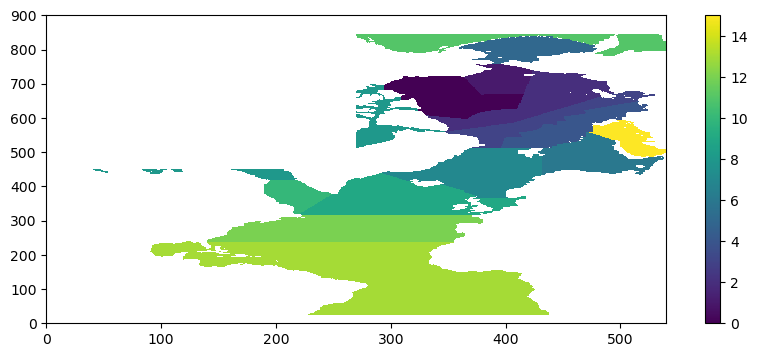

In [2]:
# copy over the mask
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# we have to add in until the edge of novaya zemlya
mymsk2 = get_aste_tracer(mymsk,nfx,nfy)[0]
mymsk2[:487,510:] = 1
mymsk2[:490,532:] = 1
mymsk = aste_tracer2compact(mymsk2,nfx,nfy)[0]

# remember to mask with land so we have the correct item
mymsk = mymsk * hfC[0]
mymsk[mymsk == 0] = np.nan


# extend the Barents Sea up to the gate between NZ--RU
mskBasin[mymsk == 1] = 6

ind2d_aste = get_aste_tracer(np.reshape(mskBasin,(ny,nx)),nfx,nfy)
plt.pcolormesh(ind2d_aste[0,:,:])
plt.colorbar()

ind2d = mskBasin.reshape(364500)
ind2d.shape
# iBarentsS2D = np.where(ind2d == 7)[0]

mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

ind2d_wet = ind2d[iwetC2d]
iwet_BarentsS2D = np.where(ind2d_wet == 6)[0]
iwet_mine = iwet_BarentsS2D
imask = np.where(ind2d == -1)[0]
iwet_mymsk = np.where(ind2d_wet == 6)[0]

In [3]:
# based on the Barton paper we would likely split on the 220m isobath

## identify the polar front -- do a map with the masks and the gates fully

In [4]:
# ocean and ice
AB_gT=0
AB_gS=0
dt_aste = 600
startyr = 2002
endyr = 2019              # for ASTE R1

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)
allyears = np.arange(2003,2018,1)

In [5]:
# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan

In [6]:
# plot the basins, color by label
landmsk = np.zeros((ny,nx))
landmsk[np.isnan(hfC[0])] = 2
landmsk[hfC[0] == 1] = np.nan
hfC[hfC<1] = np.nan

In [7]:
# define the gateways
x_bso = gg['BarentsSeaOpening']["ix"]-1   # 0 
y_bso = gg['BarentsSeaOpening']["jy"]-1
x_bso[x_bso == 162] = 161

x_sfj = gg['Svalbard-FranzJosefIslands']["ix"]-1   # 1
y_sfj = gg['Svalbard-FranzJosefIslands']["jy"]-1
x_sfj,y_sfj = x_sfj[1:],y_sfj[1:]

x_fjnz = gg['FranzJosefIslands-NovayaZemlya']["ix"]-1  #2 
y_fjnz = gg['FranzJosefIslands-NovayaZemlya']["jy"]-1

x_nzru = np.full((5),37)
y_nzru = np.arange(460,465,1)

gates = np.full(mskBasin.shape,np.nan)
gates[y_bso,x_bso] = 1
gates[y_sfj,x_sfj] = 2
gates[y_fjnz,x_fjnz] = 3
gates[y_nzru,x_nzru] = 4

In [8]:
# define the sea ice extent for March
tstart = 3

# we should also load the mean sea ice edge so we can plot this on bathymetry with the gates
# do SIarea

# loop through the years to create the timeseries
alldatetimes = np.array([])
SIareas = np.zeros((len(allyears[tstart:]),ny,nx))

iy = 0
for year in allyears[tstart:]:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
  
    march_tsstr = tsstr[2]
    
    # read the fldList
    file_name = 'state_2d_set1'
    meta_state_2d_set1 = parsemeta(dirState + file_name + "." + march_tsstr + ".meta")
    fldlist = np.array(meta_state_2d_set1["fldList"])
    varnames = np.array(["SIarea"])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])

    
    
    # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
    read = int(tsstr[2])  # march
    SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
    SIarea = np.reshape(SIareai,(ny,nx))#*mymsk  # fraction of SIarea    
    SIareas[iy] = SIarea

    iy += 1

2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [9]:
# define the ice edge to plot
SI_early_tr = get_aste_tracer(np.nanmean(SIareas[:2], axis=0),nfx,nfy)[0]     # 20
SI_early_tr = get_aste_tracer(SIareas[1],nfx,nfy)[0]
SI_mid_tr = get_aste_tracer(np.nanmean(SIareas[6:8], axis=0),nfx,nfy)[0]      # 20
SI_late_tr = get_aste_tracer(np.nanmean(SIareas[-2:], axis=0),nfx,nfy)[0]      # 20
SI_late_tr = get_aste_tracer(SIareas[-2],nfx,nfy)[0]

mymsk_tr = np.where(np.isnan(mymsk), 0, mymsk)

# Step 1: Get land mask on tracer grid
landmask_tr = get_aste_tracer(landmsk, nfx, nfy)[0] > 0  # Boolean mask where land is True

# Step 2: Expand land by 1 grid cell in all directions
landbuffer_tr = binary_dilation(landmask_tr, iterations=1)

SI_early_tr_masked = np.where(landbuffer_tr, np.nan, SI_early_tr)
SI_mid_tr_masked = np.where(landbuffer_tr, np.nan, SI_mid_tr)
SI_late_tr_masked  = np.where(landbuffer_tr, np.nan, SI_late_tr)

In [10]:
# --- Bathymetry Colormap ---
colors = ['#7fcce0', '#3f479b', '#544596', '#534694', '#754898', '#9b4696', '#bd4896',
          '#d13b8d', '#e50f7c', '#e4034b', '#e3030e', '#e11108', '#e34b05', '#f18901',
          '#fcc903', '#f5e707', '#cfd600', '#a2c60e', '#7ebc20', '#6fb528', '#72b628', '#74bd6b']
bounds = [0, 10, 20, 30, 50, 75, 100, 125, 150, 175, 200, 225, 250, 275, 300,
          400, 500, 750, 1000, 1500, 2000, 4000, 6000]
cmap = mcolors.ListedColormap(colors)
norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N, clip=True)

In [11]:
land_data = get_aste_tracer(landmsk, nfx, nfy)[0]
lon = get_aste_tracer(mygrid['XC'],nfx,nfy)[0]
lat = get_aste_tracer(mygrid['YC'],nfx,nfy)[0]

In [12]:
from matplotlib.colors import ListedColormap as ListedColormap

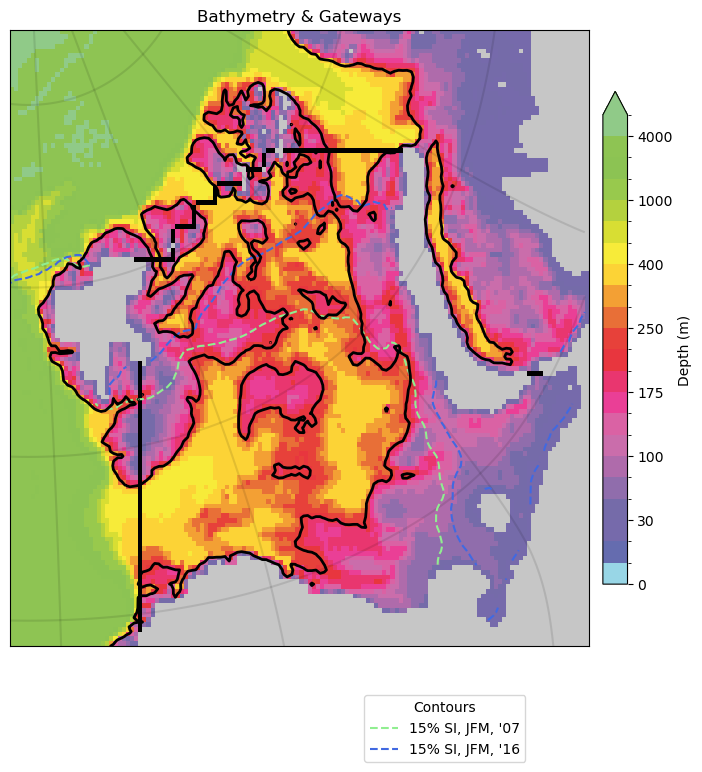

In [13]:
# --- Figure Setup ---
fig, ax0 = plt.subplots(figsize=(9, 8))

# ========== Bathymetry ==========
depth_data = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
pc = ax0.pcolormesh(depth_data, cmap=cmap, norm=norm, alpha=0.8)
ax0.pcolormesh(land_data, cmap="Greys", zorder=2, vmin=0, vmax=6)
ax0.contour(lat, levels=np.arange(70, 90, 5), colors="k", alpha=.1)
ax0.contour(lon, levels=np.arange(10, 80, 20), colors="k", alpha=.1)
ax0.contour(SI_early_tr_masked, levels=[0.15], colors='lightgreen',
            linewidths=1.5, linestyles='--')
ax0.contour(SI_late_tr_masked, levels=[0.15], colors='royalblue',
            linewidths=1.5, linestyles='--')

# Plot gateways
black_cmap = ListedColormap(['black'])
ax0.pcolormesh(get_aste_tracer(gates, nfx, nfy)[0], cmap=black_cmap)
# ax0.pcolormesh(get_aste_tracer(bit_mask, nfx, nfy)[0], cmap=black_cmap,
#                zorder=2, vmin=0.5, vmax=1.2)

# Colorbar
cb0 = fig.colorbar(pc, ax=ax0, orientation='vertical',
                   label="Depth (m)", extend="max", shrink=0.8, pad=0.02,
                   boundaries=bounds)

# Formatting
ax0.set_xlim(400, 540)
ax0.set_ylim(430, 560)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title("Bathymetry & Gateways", fontsize=12)
ax0.contour(depth_data, levels=[220], colors='k', linewidths=2, linestyles='-', zorder=3)


# Legend
legend_elements = [
    Line2D([0], [0], color='lightgreen', linestyle='--', linewidth=1.5,
           label="15% SI, JFM, '07"),
    Line2D([0], [0], color='royalblue', linestyle='--', linewidth=1.5,
           label="15% SI, JFM, '16"),
]
ax0.legend(handles=legend_elements, loc='lower left',
           bbox_to_anchor=(.6, -.2), fontsize=10,
           frameon=True, title='Contours')

plt.show()

(400.0, 600.0)

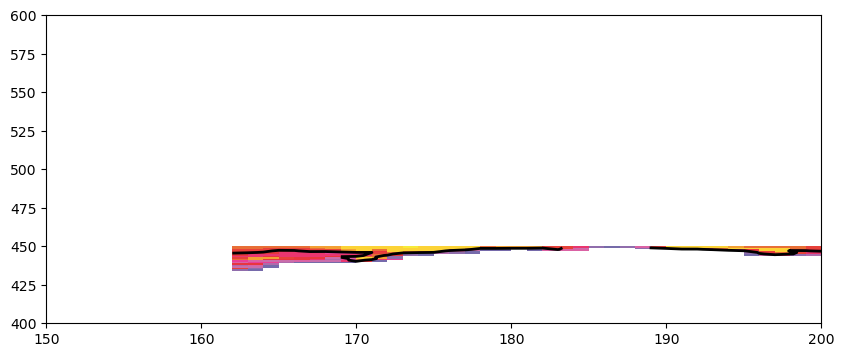

In [14]:
# Window (note: rows = y, cols = x)
x0, x1 = 30, 50
y0, y1 = 503, 525

# Make sure depth is a masked array (avoid zeros outside basin)
myd = np.ma.array(mygrid['Depth'], mask=(mskBasin != 6))

# 220 m everywhere except inside the window
Z220 = np.ma.array(myd, copy=True)
Z220.mask[y0:y1, x0:x1] = True

# 270 m only inside the window
Z270 = np.ma.array(myd, mask=np.ones_like(myd, dtype=bool))
Z270.mask[y0:y1, x0:x1] = False

# Build a cut mask: remove where (x>=49) OR ((x>=47) AND (y>515))
ny, nx = myd.shape
yy, xx = np.ogrid[:ny, :nx]
cut = (xx >= 49.5) & (xx < 100) | ((xx >= 48.5) & (yy > 515))
cut |= ((yy >= 510) & (yy <= 533) & (xx <= 41) & (xx >= 10))
cut |= ((yy >= 500) & (yy <= 506) & (xx <= 38) & (xx >= 20))
cut |= ((yy >= 490) & (yy <= 495) & (xx <= 17) & (xx >= 14))
cut |= ((yy >= 495) & (yy <= 515) & (xx >= 28) & (xx <= 31))
cut |= ((yy >= 540) & (yy <= 560) & (xx >= 45) & (xx <= 50))
cut |= ((yy >= 555) & (yy <= 560) & (xx >= 32) & (xx <= 36))

# for the other face
cut |= ((yy >= 440) & (yy <= 444) & (xx >= 160) & (xx <= 168))
cut |= ((yy >= 425) & (yy <= 444) & (xx >= 160) & (xx <= 168))
cut |= ((yy >= 425) & (yy <= 444) & (xx >= 160) & (xx <= 168))
Z220.mask |= cut
Z270.mask |= cut

plt.pcolormesh(myd, cmap=cmap, norm=norm, alpha=0.8)
cs220 = plt.contour(Z220, levels=[220], colors='k', linewidths=2, linestyles='-', zorder=3)
cs270 = plt.contour(Z270, levels=[270], colors='r', linewidths=2, linestyles='-', zorder=3)
coords220 = [p.vertices for p in cs220.collections[0].get_paths()]
coords270 = [p.vertices for p in cs270.collections[0].get_paths()]

plt.xlim(150,200)
plt.ylim(400,600)

In [37]:
# Build combined array
pts = []

# 220: first segment
pts.extend(cs220.allsegs[0][0])

# 270: all segments
for seg in cs270.allsegs[0]:
    pts.extend(seg)

# 220: the rest of the segments (after index 0)
for seg in cs220.allsegs[0][1:]:
    pts.extend(seg)

# Convert to numpy array
all_pts = np.array(pts)   # shape (N, 2)
all_pts = all_pts.astype(int)
# all_pts

In [38]:
x_bso
y_bso.shape

(63,)

In [39]:
# set a mesh, color by all_pts for a "wall"
PF_mask = np.full((ny,nx),np.nan)

for arr in all_pts:
    PF_mask[arr[1],arr[0]] = 1
    
for i,j in zip(x_bso[14:36],y_bso[14:36]):
    PF_mask[j,i] = 1

(400.0, 600.0)

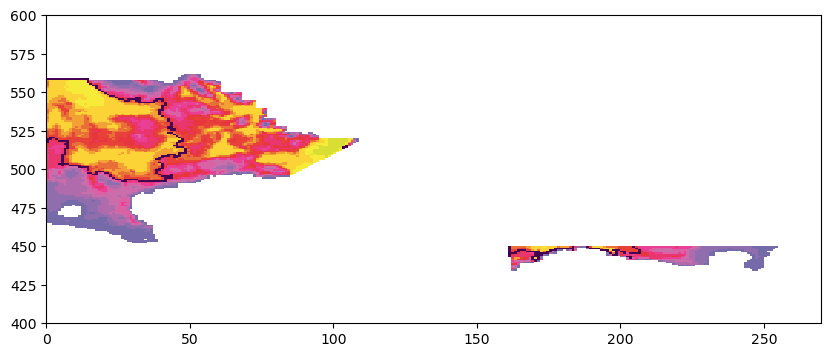

In [40]:
plt.pcolormesh(myd, cmap=cmap, norm=norm, alpha=0.8)
plt.pcolormesh(PF_mask)
plt.ylim(400, 600)

(400.0, 540.0)

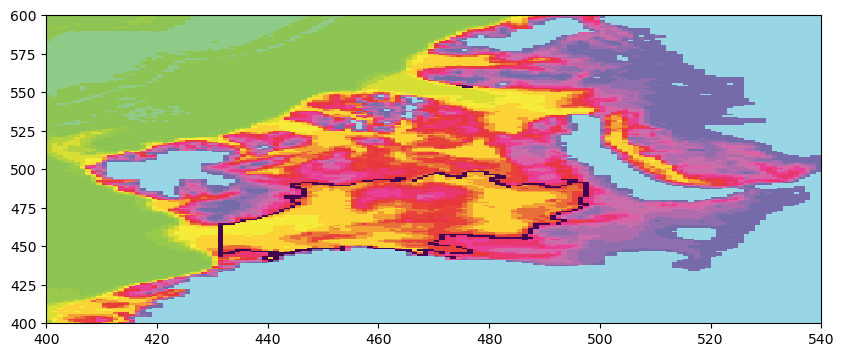

In [41]:
plt.pcolormesh(depth_data, cmap=cmap, norm=norm, alpha=0.8)
    
plt.pcolormesh(get_aste_tracer(PF_mask,nfx,nfy)[0])
plt.ylim(400, 600)
plt.xlim(400,540)

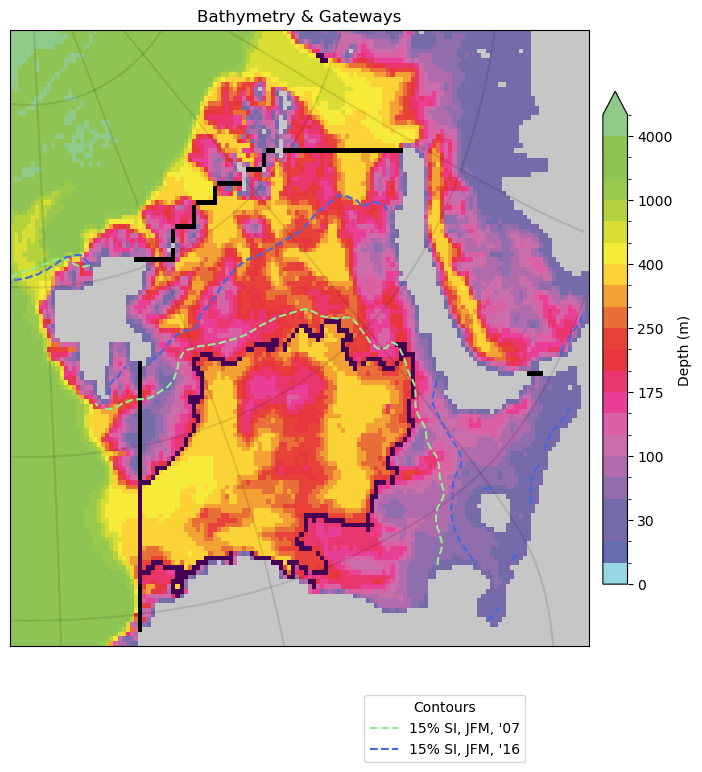

In [42]:
# --- Figure Setup ---
fig, ax0 = plt.subplots(figsize=(9, 8))

# ========== Bathymetry ==========
depth_data = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
pc = ax0.pcolormesh(depth_data, cmap=cmap, norm=norm, alpha=0.8)
ax0.pcolormesh(land_data, cmap="Greys", zorder=2, vmin=0, vmax=6)
ax0.contour(lat, levels=np.arange(70, 90, 5), colors="k", alpha=.1)
ax0.contour(lon, levels=np.arange(10, 80, 20), colors="k", alpha=.1)
ax0.contour(SI_early_tr_masked, levels=[0.15], colors='lightgreen',
            linewidths=1.5, linestyles='--')
ax0.contour(SI_late_tr_masked, levels=[0.15], colors='royalblue',
            linewidths=1.5, linestyles='--')

# Plot gateways
black_cmap = ListedColormap(['black'])
ax0.pcolormesh(get_aste_tracer(gates, nfx, nfy)[0], cmap=black_cmap)
# ax0.pcolormesh(get_aste_tracer(bit_mask, nfx, nfy)[0], cmap=black_cmap,
#                zorder=2, vmin=0.5, vmax=1.2)

# Colorbar
cb0 = fig.colorbar(pc, ax=ax0, orientation='vertical',
                   label="Depth (m)", extend="max", shrink=0.8, pad=0.02,
                   boundaries=bounds)

# Formatting
ax0.set_xlim(400, 540)
ax0.set_ylim(430, 560)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title("Bathymetry & Gateways", fontsize=12)
# ax0.contour(depth_data, levels=[220], colors='k', linewidths=2, linestyles='-', zorder=3)
ax0.pcolormesh(get_aste_tracer(PF_mask,nfx,nfy)[0])


# Legend
legend_elements = [
    Line2D([0], [0], color='lightgreen', linestyle='--', linewidth=1.5,
           label="15% SI, JFM, '07"),
    Line2D([0], [0], color='royalblue', linestyle='--', linewidth=1.5,
           label="15% SI, JFM, '16"),
]
ax0.legend(handles=legend_elements, loc='lower left',
           bbox_to_anchor=(.6, -.2), fontsize=10,
           frameon=True, title='Contours')

plt.show()


In [46]:
# import numpy as np
# from matplotlib.path import Path

# # 1) Same ordered, closed polygon of (x,y) vertices as above
# poly_xy = np.vstack([all_pts, np.column_stack([x_bso[14:36], y_bso[14:36]])])
# if not np.array_equal(poly_xy[0], poly_xy[-1]):
#     poly_xy = np.vstack([poly_xy, poly_xy[0]])

# # 2) Build grid of pixel centers in index space
# cols = np.arange(nx)       # x
# rows = np.arange(ny)       # y
# XX, YY = np.meshgrid(cols, rows)
# centers = np.column_stack([XX.ravel(), YY.ravel()])  # (Npix, 2)

# # 3) Point-in-polygon test at centers (treat boundary as inside with a tiny radius)
# poly_path = Path(poly_xy)
# inside = poly_path.contains_points(centers, radius=1e-9)  # include edges
# PF_mask = inside.reshape(ny, nx)

# # 4) Move to tracer grid, then cut
# PF_mask_tr = get_aste_tracer(PF_mask.astype(float), nfx, nfy)[0] == 1
# PF_mask_tr[520:, :] = False
# # PF_mask_tr[:, :430] = False


In [47]:
# PF_mask_tr.shape

In [48]:
# plt.pcolormesh(PF_mask_tr)

In [22]:
from matplotlib.patches import Polygon

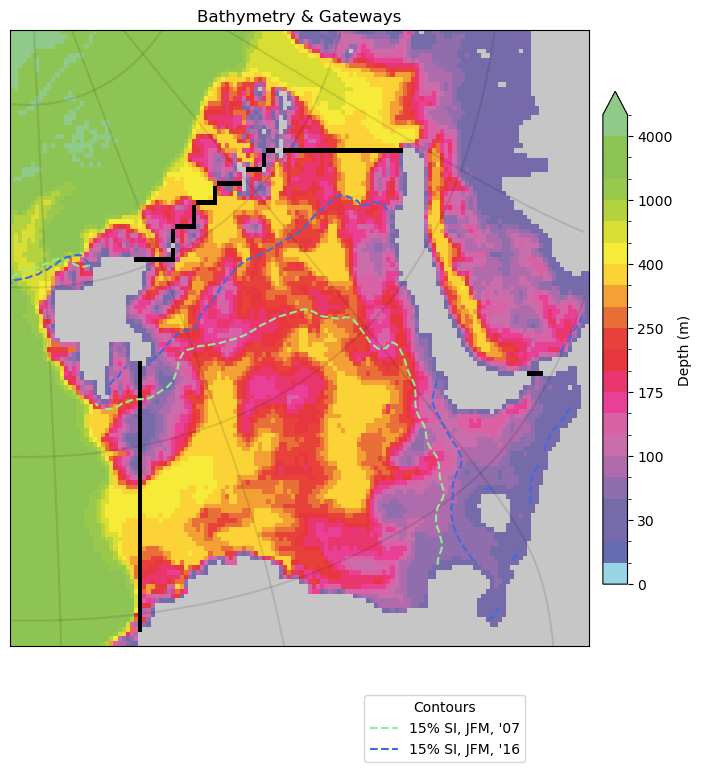

In [43]:
# --- Figure Setup ---
fig, ax0 = plt.subplots(figsize=(9, 8))

# ========== Bathymetry ==========
depth_data = get_aste_tracer(mygrid['Depth'], nfx, nfy)[0]
pc = ax0.pcolormesh(depth_data, cmap=cmap, norm=norm, alpha=0.8)
ax0.pcolormesh(land_data, cmap="Greys", zorder=2, vmin=0, vmax=6)
ax0.contour(lat, levels=np.arange(70, 90, 5), colors="k", alpha=.1)
ax0.contour(lon, levels=np.arange(10, 80, 20), colors="k", alpha=.1)
ax0.contour(SI_early_tr_masked, levels=[0.15], colors='lightgreen',
            linewidths=1.5, linestyles='--')
ax0.contour(SI_late_tr_masked, levels=[0.15], colors='royalblue',
            linewidths=1.5, linestyles='--')

# Plot gateways
black_cmap = ListedColormap(['black'])
ax0.pcolormesh(get_aste_tracer(gates, nfx, nfy)[0], cmap=black_cmap)
# ax0.pcolormesh(get_aste_tracer(bit_mask, nfx, nfy)[0], cmap=black_cmap,
#                zorder=2, vmin=0.5, vmax=1.2)

# Colorbar
cb0 = fig.colorbar(pc, ax=ax0, orientation='vertical',
                   label="Depth (m)", extend="max", shrink=0.8, pad=0.02,
                   boundaries=bounds)

# Formatting
ax0.set_xlim(400, 540)
ax0.set_ylim(430, 560)
ax0.set_xticks([])
ax0.set_yticks([])
ax0.set_title("Bathymetry & Gateways", fontsize=12)
# ax0.contour(depth_data, levels=[220], colors='k', linewidths=2, linestyles='-', zorder=3)
# ax0.pcolormesh(get_aste_tracer(PF_mask,nfx,nfy)[0])
# poly_patch = Polygon(poly_xy, closed=True, facecolor='C0', alpha=0.3, edgecolor='k')
# ax0.add_patch(poly_patch)


# Legend
legend_elements = [
    Line2D([0], [0], color='lightgreen', linestyle='--', linewidth=1.5,
           label="15% SI, JFM, '07"),
    Line2D([0], [0], color='royalblue', linestyle='--', linewidth=1.5,
           label="15% SI, JFM, '16"),
]
ax0.legend(handles=legend_elements, loc='lower left',
           bbox_to_anchor=(.6, -.2), fontsize=10,
           frameon=True, title='Contours')

plt.show()


In [44]:
PF_mask_tr = get_aste_tracer(PF_mask,nfx,nfy)[0]
PF_mask_tr[510:] = np.nan
PF_mask = aste_tracer2compact(PF_mask_tr,nfx,nfy)[0]

rows, cols = np.where(get_aste_tracer(PF_mask, nfx, nfy)[0] == 1)

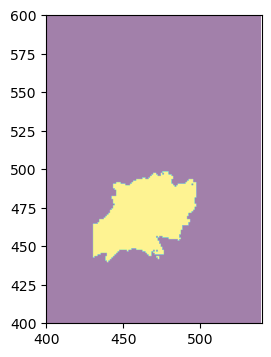

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

# ---------- helpers ----------
def bresenham_line(x0, y0, x1, y1):
    x0, y0, x1, y1 = int(round(x0)), int(round(y0)), int(round(x1)), int(round(y1))
    pts = []
    dx = abs(x1 - x0); sx = 1 if x0 < x1 else -1
    dy = -abs(y1 - y0); sy = 1 if y0 < y1 else -1
    err = dx + dy; x, y = x0, y0
    while True:
        pts.append((x, y))
        if x == x1 and y == y1: break
        e2 = 2 * err
        if e2 >= dy: err += dy; x += sx
        if e2 <= dx: err += dx; y += sy
    return np.array(pts, dtype=int)

def order_points_nearest(points_xy):
    """Greedy nearest-neighbor ordering to make a loop."""
    pts = points_xy.copy()
    used = np.zeros(len(pts), dtype=bool)
    start = np.lexsort((pts[:,1], pts[:,0]))[0]  # leftmost, then lowest
    order = [start]; used[start] = True; curr = start
    for _ in range(len(pts)-1):
        diff = pts[~used] - pts[curr]
        d2 = np.einsum('ij,ij->i', diff, diff)
        nxt = np.where(~used)[0][np.argmin(d2)]
        order.append(nxt); used[nxt] = True; curr = nxt
    return pts[order]

def raster_fill_from_polygon(poly_xy, ny, nx):
    cols = np.arange(nx); rows = np.arange(ny)
    XX, YY = np.meshgrid(cols, rows)
    centers = np.column_stack([XX.ravel(), YY.ravel()])
    inside = Path(poly_xy).contains_points(centers, radius=1e-9)
    return inside.reshape(ny, nx)

from matplotlib.path import Path

def outer_ring_from_points(points_xy, nbins=720, center=None):
    """
    Build an ordered, non-self-intersecting outer boundary from scattered edge pixels
    by angular binning and taking the farthest point per angle bin.
    - points_xy: (N,2) array of [x, y] in index space
    - nbins: angular bins (higher => smoother boundary)
    - center: optional [cx, cy]; default = mean of points
    """
    pts = np.asarray(points_xy, dtype=float)
    if center is None:
        center = pts.mean(axis=0)  # or use np.median for robustness

    d = pts - center
    theta = np.arctan2(d[:,1], d[:,0])
    theta = (theta + 2*np.pi) % (2*np.pi)  # [0, 2π)
    r = np.hypot(d[:,0], d[:,1])

    # bin angles and keep farthest radius per bin
    bin_width = 2*np.pi / nbins
    bins = np.floor(theta / bin_width).astype(int)

    best_idx = {}
    for i, b in enumerate(bins):
        if (b not in best_idx) or (r[i] > r[best_idx[b]]):
            best_idx[b] = i

    # collect in increasing angle order
    sel = np.array(sorted(best_idx.values(), key=lambda i: theta[i]))
    ring = pts[sel]

    # close loop
    if not np.array_equal(ring[0], ring[-1]):
        ring = np.vstack([ring, ring[0]])
    return ring


# === use it in your pipeline ===
PF_tr = get_aste_tracer(PF_mask, nfx, nfy)[0]
r, c = np.where(PF_tr == 1)
edge_pts = np.unique(np.column_stack([c, r]), axis=0)  # [x,y]

# build ordered outer boundary
poly_xy = outer_ring_from_points(edge_pts, nbins=720)  # try 360–1080 if needed

# fill by point-in-polygon at cell centers (your function)
ny_tr, nx_tr = PF_tr.shape
cols = np.arange(nx_tr); rows = np.arange(ny_tr)
XX, YY = np.meshgrid(cols, rows)
centers = np.column_stack([XX.ravel(), YY.ravel()])
poly_mask_tr = Path(poly_xy).contains_points(centers, radius=1e-9).reshape(ny_tr, nx_tr)

# (optional) also paint the boundary pixels so you see the outline
poly_mask_tr[poly_xy[:-1,1].astype(int), poly_xy[:-1,0].astype(int)] = True

# ---------- 5) visualize ----------
fig, ax = plt.subplots()
ax.imshow(poly_mask_tr, origin='lower', alpha=0.5)            # filled region
# ax.plot(poly_xy[:,0], poly_xy[:,1], '-o', ms=2, color='k')    # boundary path
ax.set_aspect('equal', adjustable='box')

ax.set_xlim(400,540)
ax.set_ylim(400,600)

plt.show()

## save this as a mask

In [51]:
poly_mask_tr.shape
poly_mask = aste_tracer2compact(poly_mask_tr,nfx,nfy)[0]

# save this one as a mask:
np.save("poly_mask.npy", poly_mask)

## We also want to save where 